#  State tracking and state error feedback
**⚠️  Optional Advanced method**
The contents of this module cover advanced topics that not all students are expected to understand.




Imagine you're trying to keep track of a friend's location as they move around a city. You might predict their movement based on their planned route and speed, or receive updates from them via text messages about where they are. However, both methods have uncertainties: your predictions might be off if they take a detour or get delayed, and their updates might be inaccurate due to typos or delayed messages. To get the best estimate of your friend's actual location, you need to combine both your predictions and their updates in a smart way.

This is where the Kalman filter comes into play. The Kalman filter is like a sophisticated tool that helps you estimate the true state of something—like your friend's location—by predicting the next state based on a model (such as their expected route and speed) and updating this prediction with new observations (like their text messages). It weighs both the prediction and the observation based on how much you trust them.

But why do we need it? In many systems, especially in engineering and robotics, we need to know the current state—like position and speed—to make decisions or control actions. Measurements, such as sensor readings, are often noisy or imperfect, and models, like equations of motion, might not capture every real-world nuance. By using a Kalman filter, we can improve our estimates by combining predictions and observations, account for uncertainties in both the model and the measurements, and make better decisions based on more accurate state information.

Think about using GPS navigation in your car. GPS signals provide your location but can be inaccurate due to signal loss or interference, while the car's motion model knows your car moves forward, turns, and so on. The navigation system uses a Kalman filter to predict where you should be based on your last known position and how fast you're driving, and then updates this prediction with new GPS data. This allows it to estimate your current position more accurately than using either method alone.

The Kalman filter adjusts how much it trusts the model versus the measurements. If the measurements are noisy—for example, due to a poor GPS signal—it relies more on the model prediction. If the model is uncertain, such as when movement is unpredictable, it trusts the measurements more. The filter calculates a Kalman gain, which determines this balance.

This is important in control systems like autonomous vehicles or robots, where making precise movements depends on knowing the current state accurately. State tracking involves continuously estimating the true state (position, velocity), and state error feedback uses the difference between the estimated state and the desired state to adjust control actions. By effectively tracking the state and accounting for errors, we achieve improved performance—the system can respond accurately to changes—robustness—the system can handle uncertainties and disturbances—and efficiency, optimizing the use of inputs like steering and acceleration.



So as said in the signal processing/control literature, Kalman filters are used to estimate the state (position, velocity) of a system, given its inputs and observed (noisy) outputs. This assumes linear systems in state-space form (either continuous-time or discrete-time): in discrete time, you model

$$
\left\{
\begin{array}{lcl}
  \mathbf{x}_k &=& \mathbf{A} \mathbf{x}_{k-1} + \mathbf{B} \mathbf{u}_k + \mathbf{w}_k \\
  \mathbf{y}_k  &=& \mathbf{C} \mathbf{x}_k + \mathbf{v}_k
\end{array}
\right.
$$

Here, $\mathbf{u}_k$ is the system input at time $k$ (your velocity and steering commands), $\mathbf{x}$ is the (true) state vector, and $\mathbf{y}_k$ is an observation, in our case your position estimator. For example, for moving in 1D on a line, without friction, and with a discretization time step $\Delta T$,

$$
\mathbf{x} = \left[\begin{array}{c}
   z \\
   v
  \end{array}\right] \,, \qquad
\mathbf{A} = \left[\begin{array}{cc}
     1 & \Delta T \\
 0 & 1
\end{array}\right] \,, \qquad
\mathbf{u} = F_a \,, \qquad
\mathbf{B} = \left[\begin{array}{c}
    0 \\ \frac{1}{m} \end{array}\right] \,, \qquad
\mathbf{C} = [1 \quad 0] \,.
$$

The disturbances $\mathbf{v}_k$ and $\mathbf{w}_k$ are unknown additive noise processes at the input and the output, respectively, that will make the state and the output deviate from their real values. The Kalman filter is an estimator for $\mathbf{x}_k$ given $\mathbf{u}_k$ and $\mathbf{y}_k$ (and the previous state estimate at time $k-1$); it tries to track this state; it is a topic for MSc-level courses (e.g., EE4C03). The fundamental idea here is that you do not have access to the true state $\mathbf{x}_k$, you only have estimates $\hat{\mathbf{x}}_k$ that you keep updated.

If the observation noise $\mathbf{v}_k$ is high, then you don't trust the measurements $\mathbf{y}_k$, and will estimate the next state as $\hat{\mathbf{x}}_k = \mathbf{A} \hat{\mathbf{x}}_{k-1} + \mathbf{B} \mathbf{u}_k$, i.e., using the model predictions only. On the other hand, if the input (state) noise $\mathbf{w}_k$ is high, you don't trust the model state update and estimate the state (position, velocity) mostly from the observations. The Kalman filter gives a weighted average of these two extremes, using something called the Kalman gain. Our trust is modeled by covariance matrices $\mathbf{Q}_w = \mathbb{E}[\mathbf{w}_k\mathbf{w}_k^T]$ and $\mathbf{Q}_v = \mathbb{E}[\mathbf{v}_k\mathbf{v}_k^T]$. For example, $\mathbf{Q}_w$ contains on its main diagonal the measurement noise variance on your position estimates, which you documented in the preceding Modules. $\mathbf{Q}_v$ is the jitter on your input, and you could measure this by repeatedly giving the same control inputs and seeing how the state varies (measuring the state with a ruler rather than the less accurate beacon locator).

Kalman filters are described in many books, see e.g. Chapter 7.4 in

> Monson H. Hayes, *Statistical digital signal processing and modeling*, John Wiley and Sons, New York, 1996. ISBN: 0-471-59431-8.

Unfortunately, steering a car is highly nonlinear. You could try to use an Extended Kalman filter. Alternatively, since you have your own car model, you can use that to predict the next location and state, given the same inputs, and use the observed error in position to update/correct your state estimate, similar to what a Kalman filter does.

A complete theory is not developed here, the above is meant as inspiration for your own solution! However below you can see an example of Kalman filter for tracking a moving object. This should be adjusted for the case of KITT.

### Example: Tracking a Moving Object with a Kalman Filter

So here we use **Kalman Filter** to estimate the position of a moving object based on noisy measurements. 

1. **Problem**: We have an object moving in 1D at a constant velocity (this could be for instacne KITT), but we can only measure its position with noise. The goal is to estimate the true position and velocity of the object over time.

2. **Approach**:
   - Here we use simulation for noisy position measurements as the object moves. in practice you get data from your noisy estimations. 
   - The Kalman Filter processes these noisy measurements to provide a more accurate estimate of the object's position and velocity.

3. **Steps in the Code**:
   - **Prediction**: The Kalman Filter predicts where the object will be based on its current state (position and velocity).
   - **Update**: It compares the prediction to the noisy measurement, adjusts the estimate, and reduces uncertainty.
   
   
The script plots three lines:
   - The true position of the object (which is hidden in practice).
   - The noisy position measurements.
   - The Kalman Filter's position estimate, which is much closer to the true position than the noisy measurements.


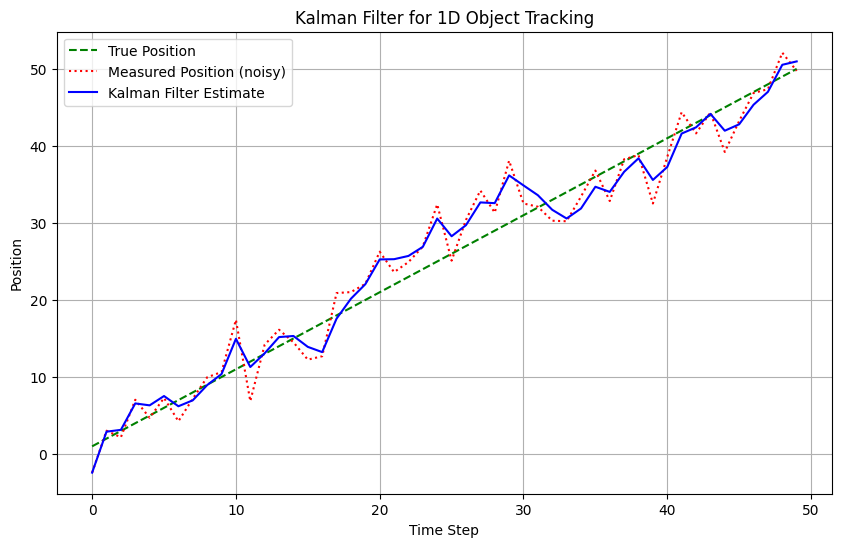

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 1.0  # Time step (in seconds)
num_steps = 50  # Number of time steps

# Ground truth initial state (position and velocity)
true_position = 0.0
true_velocity = 1.0

# Kalman Filter parameters
# Initial state estimate (position, velocity)
x = np.array([[0], [0]])

# Initial uncertainty covariance matrix
P = np.array([[1000, 0], 
              [0, 1000]])

# State transition matrix (models constant velocity)
F = np.array([[1, dt], 
              [0, 1]])

# Measurement matrix (we only measure position)
H = np.array([[1, 0]])

# Measurement noise covariance (assume noisy position sensor)
R = np.array([[10]])

# Process noise covariance matrix (assumes some uncertainty in system dynamics)
Q = np.array([[1, 0], 
              [0, 1]])

# Storage for plotting
true_positions = []
measured_positions = []
kalman_positions = []

# Simulate the system
for step in range(num_steps):
    # Simulate true object position (with perfect velocity)
    true_position += true_velocity * dt
    true_positions.append(true_position)

    # Simulate noisy measurement (position with noise)
    measurement = true_position + np.random.normal(0, np.sqrt(R[0, 0]))
    measured_positions.append(measurement)
    
    # Kalman Filter prediction step
    x = F @ x  # State prediction
    P = F @ P @ F.T + Q  # Covariance prediction

    # Kalman Filter update step
    y = measurement - H @ x  # Measurement residual (innovation)
    S = H @ P @ H.T + R  # Residual covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain

    x = x + K @ y  # Updated state estimate
    P = (np.eye(2) - K @ H) @ P  # Updated covariance estimate
    
    kalman_positions.append(x[0, 0])  # Save the filtered position

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(true_positions, label='True Position', color='g', linestyle='--')
plt.plot(measured_positions, label='Measured Position (noisy)', color='r', linestyle=':')
plt.plot(kalman_positions, label='Kalman Filter Estimate', color='b')
plt.title('Kalman Filter for 1D Object Tracking')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()
